In [405]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import BorderlineSMOTE
import xgboost as xgb
from collections import Counter
import sklearn
from sklearn.metrics import recall_score

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/willcline/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/willcline/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [302]:
df16_url = "../../data/df1516final.csv"
df20_url = "../../data/df1920final.csv"

In [303]:
df16 = pd.read_csv(df16_url)

In [304]:
df20 = pd.read_csv(df20_url)

In [318]:
# Target
y20 = df20['target']
y16 = df16["target"]
# Features
X16 = df16.drop('target', axis=1)
X20 = df20.drop('target', axis=1)

### Splits

Train test split 2016 as per usual
Train test val split 2020
Append 2020 train to 2016 train, append 2020 val to 2016 val.

#### Split 2016 into train test

In [308]:
X_train16, X_test16, y_train16, y_test16 = train_test_split(X16, y16, test_size=.15, random_state=42)

#### append train and vals of 2016 and 2020 into general X_train and y_train

In [321]:
X_train = X_train16
X_test = X_test16
y_train = y_train16
y_test = y_test16

### Imputer

In [315]:
# Instantiate a SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")

In [316]:
# Fit on training data
imputer.fit(X_train)

SimpleImputer(strategy='most_frequent')

In [350]:
# Transform training and validation data
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X16.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X16.columns)
X20_imputed = pd.DataFrame(imputer.transform(X20), columns=X16.columns)

### Smote

In [352]:
oversample = BorderlineSMOTE()
X_train, y_train = oversample.fit_resample(X_train_imputed, y_train)

In [353]:
counter = Counter(y_train)
print(counter)

Counter({1: 338, 0: 338})


### Feature Scaling

In [354]:
cols = list(X16.columns)

In [355]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [356]:
# fit on Imputed training data
scaler.fit(X_train)

StandardScaler()

In [357]:
# transform training and validation data
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed), columns=cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=cols)
X20_scaled = pd.DataFrame(scaler.transform(X20_imputed), columns=cols)

In [374]:
#MY step to rename scaled data
X_train_df = X_train_scaled
X_test_df = X_test_scaled
X20_df = X_test_scaled

## Modeling

In [375]:
def modeling_function(model, X_train, y_train, X_val, y_val):

    # fit model on training data
    model.fit(X_train, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Print accuracy score
    print('Training F1 score: ', f1_score(y_train, train_preds))
    print('Validation F1 score: ', f1_score(y_val, val_preds))

    # return fitted model
    return model

In [376]:
def model_test_evaluation(model, X_test, y_test):

    # make predictions on test data
    test_preds = model.predict(X_test)

    # Print accuracy score
    print('Test F1 Score: ', f1_score(y_test, test_preds))

### Baseline

In [377]:
logreg = LogisticRegression(solver='liblinear')

In [380]:
# call modeling function
logreg = modeling_function(logreg, X_train_df, y_train, X_test_df, y_test)

Training F1 score:  0.937784522003035
Validation F1 score:  0.9310344827586207


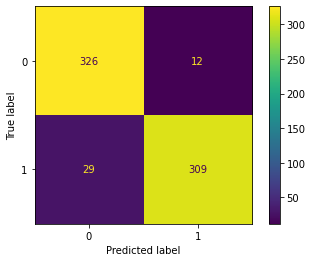

In [381]:
plot_confusion_matrix(logreg, X_train_df, y_train)

### XG Boost

In [404]:
XG = XGBRegressor()

NameError: name 'XGBRegressor' is not defined

### Grid Search

In [395]:
param_grid = {"penalty": ['l1', 'l2'],
              "C":[8, 3, 35,20] }

In [396]:
gs = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring="f1")

In [397]:
grid_result = gs.fit(X_train_df, y_train)

In [398]:
grid_result.best_params_

{'C': 3, 'penalty': 'l2'}

In [399]:
best_model = grid_result.best_estimator_

In [400]:
best_model = modeling_function(best_model, X_train_df, y_train, X_test_df, y_test)

Training F1 score:  0.9409984871406959
Validation F1 score:  0.9310344827586207


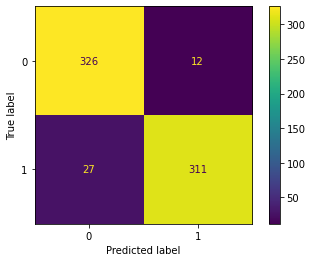

In [401]:
plot_confusion_matrix(best_model, X_train_df, y_train)

#### Test data evaluation with best model and others

In [259]:
#Best model
model_test_evaluation(best_model, X_test_df, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').